<a href="https://colab.research.google.com/github/Otwooo/AI_Practice/blob/main/%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98/%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **순환 신경망을 이용한 자연어 처리 실습(영화 리뷰 감성 분류)**
국립중앙과학관 2022 인공지능 자율탐구 프로그램 3번 과제

대전대신고 배송현



## **1. 자연어 데이터 처리 필수 패키지 설치**

In [ ]:
# 자연어 처리를 위한 기본적인 기능 제공
!pip install nltk
import nltk
nltk.download("treebank")
nltk.download("punkt")
nltk.download("wordnet")

!pip install konlpy # 형태소 분석 패키지
!pip install torchtext # 자연어 처리 라이브러리 (파이토치에서 제공)
!pip install gensim # 머신러닝 사용 토픽 모델링 및 자여어 처리 수행

# 형태소 분석기 Mecab
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh) # Mecab 오류 해결 (NameError: name 'Tagger' is not defined) 

# 네이버 한글 맞춤법 검사기 기반 패키지
!pip install git+https://github.com/ssut/py-hanspell.git

## **2. 문장 토큰화**

### **2.1 영어 문장 토큰화**

In [ ]:
en_text = "I am studying AI."
print(en_text.split())

['I', 'am', 'studying', 'AI.']


In [ ]:
from nltk.tokenize import word_tokenize

print(word_tokenize(en_text))

['I', 'am', 'studying', 'AI', '.']


`word_tokenize()`를 사용하여 문장을 토큰화하면 마침표까지  토큰으로 나뉘어진 것을 확인할 수 있다.

### **2.2 한국어 문장 토큰화**

In [ ]:
kor_text = "자연어 처리 공부하는 중입니다."
print(kor_text.split())

['자연어', '처리', '공부하는', '중입니다.']


In [ ]:
from konlpy.tag import Mecab

tokenizer = Mecab()
print(tokenizer.morphs(kor_text))

['자연어', '처리', '공부', '하', '는', '중', '입니다', '.']


띄어쓰기 단위로 단어가 구분되는 영어와 달리 한국어는 조사나 접사를 고려하여 토큰화 해야합니다.

## **3. 단어와 문장의 표준형 변환**

### **3.1 정제와 정규화**

**트큰화 작업 전후, 텍스트 데이터를 용도에 맞게 정제하고 정규화합니다.**
- 정제 : 자연어 데이터 안에 포함되어 있는 노이즈 데이터를 제거하는 것
- 정규화 : 표현 방법이 다른 단어들을 통합시켜서 같은 단어로 표현하는 것

In [ ]:
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

en_text = "He likes to go to school."
lemmatizer = WordNetLemmatizer()
words = word_tokenize(en_text)
print([lemmatizer.lemmatize(w) for w in words])

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['He', 'like', 'to', 'go', 'to', 'school', '.']


**표제어**(기본 사전형 단어) 추출로 영단어를 변환합니다.

'likes'가 'like'로 변환되었다.

In [ ]:
print([lemmatizer.lemmatize("is", "n"), lemmatizer.lemmatize("is", "v")])

['is', 'be']


**단어의 품사 정보를 제공**하면 더욱 정확하게 표제어를 추출합니다.

is의 품사를 n(명사)로 지정 -> is의 표제어를 그대로 is로 추출 (이름이기 때문에)

is의 품사를 v(동사)로 지정 -> is의 표제어를 be(be동사)로 추출

In [ ]:
from hanspell import spell_checker

kor_text = "인공징능이맞춤뻡껌사를할수있다고?"
spelled_sent = spell_checker.check(kor_text)
print(spelled_sent.checked)

인공지능이 맞춤법 껌사를 할 수 있다고?


[Py-Hanspell](https://github.com/ssut/py-hanspell) 패키지를 이용하여 맞춤법 및 뛰어쓰기를 보정할 수 있다.

고쳐지지 않은 부분이 있지만 어느정도 오타가 보정된 것을 볼 수 있다.

## **4. 단어 데이터의 숫자 표현법**

### **4.1 정수 인코딩**

정수 인코딩은 **각 단어를 고유한 정수로 표현**하는 벙법이다.

보통 빈도수가 높은 단어 순으로 숫자를 부여한다.

In [ ]:
from konlpy.tag import Mecab

tokenizer = Mecab()
text = "니가 그린 기린 그림은 목이 긴 기린 그림"
data = tokenizer.morphs(text)
word_to_index = {}
for i, word in enumerate(data):
  if word not in word_to_index.keys():
    word_to_index[word] = i
print(word_to_index)

{'니': 0, '가': 1, '그린': 2, '기린': 3, '그림': 4, '은': 5, '목': 6, '이': 7, '긴': 8}


### **4.2 원-핫 인코딩**

정수 인코딩은 각 단어를 고유한 정수로 표현했다면 원-핫 인코디은 각 단어를 **벡터**로 표현한다.

집합의 크기를 벡터의 차원으로 설정하고, 표현하고 싶은 단어의 인덱스에 값 1을, 나머지에는 0을 부여하는 **단어의 벡터 표현 방식**이다.

In [ ]:
def one_hot_encoding(word, word_to_index):
  one_hot_vector = [0]*(len(word_to_index))
  index = word_to_index[word]
  one_hot_vector[index] = 1
  return one_hot_vector
one_hot_encoding("기린", word_to_index)

[0, 0, 0, 1, 0, 0, 0, 0, 0]

기존의 정수 인코딩을 진행한 `word_to_index`을 가지고 원-핫 인코딩을 진행

## **5. 단어 집합 생성 & 시각화**


### **5.1 패키지 불러오기 & 데이터 불러오기**

In [ ]:
# 단어 집합 생성
import urllib.request
import pandas as pd
from konlpy.tag import Mecab
from nltk import FreqDist
import numpy as np
import matplotlib.pyplot as plt

# 시각화 관련 패키지
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!conda install -c conda-forge wordcloud

from wordcloud import WordCloud

Selecting previously unselected package fonts-nanum.
(Reading database ... 155958 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/bin/bash: conda: command not found


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename = "ratings.txt")

# 데이터 프레임에 저장
data = pd.read_table("ratings.txt")
print("전체 데이터 수 :", len(data))
data.head()

전체 데이터 수 : 200000


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


이 데이터는 총 20만개의 영화 리뷰를 긍정 1, 부정 0으로 라벨링한 데이터이다.

### **5.2 단어 집합 생성**

In [ ]:
from nltk import FreqDist

tokenized = []
for i in range(1000):
  tokenized.append(tokenizer.morphs(data["document"][i]))
vocab = FreqDist(np.hstack(tokenized))
print("단어 집합의 크기 : {}".format(len(vocab)))
vocab_sorted = sorted(vocab.items(), key= lambda x:x[1], reverse = True)
# print("단어 빈도수 별 정렬 :", vocab_sorted)
print("'재밌' 이라는 단어의 빈도수 : {}".format(vocab["재밌"]))

단어 집합의 크기 : 3393
'재밌' 이라는 단어의 빈도수 : 101


정수 인코딩과 원-핫 인코딩을 진행한 모습이다.

### **5.3 단어 집합 시각화**

In [ ]:
filtered_list = []
word_num = len(vocab_sorted)
for i in range(word_num):
  if len(vocab_sorted[word_num-i-1][0]) < 2:
    vocab_sorted.pop(word_num-i-1)

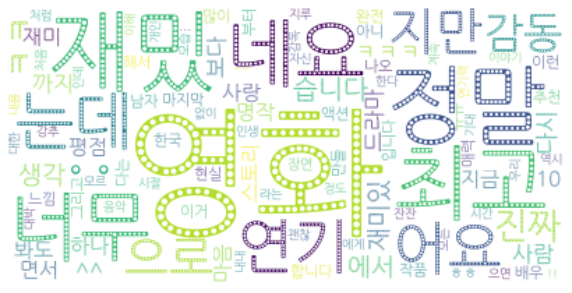

In [ ]:
font = "/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf"
wc = WordCloud(font_path=font,
               background_color="white",
               max_words=100,
               max_font_size=100)
wc = wc.generate_from_frequencies(dict(vocab_sorted))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## **6. 워드 임베딩**

**워드 임베딩**이란 단어를 **밀집 벡터**로 표현하는 방법이다. 

**밀집 벡터**란 벡터를 구성하는 원소의 대부분이 0이 아닌 것으로 해당 단어를 연속적인 값으로 표현하고 각 단어간의 유사성 또한 표현 가능하다.

이런 **워드 임베딩 방법론**에는 LSA, Word2Vec, FastText, Glove 등 다양한 알고리즘이 있다.

참고 글 : https://wikidocs.net/50739 

In [ ]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f9ac59b3f10>)

In [ ]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

In [ ]:
print(model["book"][1:5])
print(model["learning"][1:5])
print(model.similarity("cat", "dog"))
print(model.similarity("study", "banana"))

[ 0.8642023  -0.56349903  0.2713755   2.1971388 ]
[-0.7490336  -0.81585395  0.8991362   2.0268927 ]
0.8335227
-0.011861273


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.


## **7. RNN 구조의 이해**

**순환신경망**은 한 문장에서 단어 각각의 순서와 조합(시퀀스)를 모두 처리하는 가장 기본적인 모델입니다.


아래 예제에서는 RNN의 단점을 보완한 네트워크 구조인 LSTM을 사용합니다.


### **7.1 패키지 불러오기 & 데이터 불러오기**

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
import numpy as np

In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)
for i in range(len(x_train_all)):
  x_train_all[i] = [w for w in x_train_all[i] if w > 2]
random_index = np.random.permutation(25000)
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]
x_train_seq = sequence.pad_sequences(x_train, maxlen=100)
x_val_seq = sequence.pad_sequences(x_val, maxlen= 100)

17473536/17464789 [==============================] - 0s 0us/step



### **7.3 학습 진행**

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(1000,32))
model_LSTM.add(LSTM(8))
model_LSTM.add(Dense(1,activation='sigmoid'))
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 lstm (LSTM)                 (None, 8)                 1312      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_LSTM.fit(x_train_seq, y_train, 
                         epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 18s 26ms/step - loss: 0.4448 - accuracy: 0.7944 - val_loss: 0.3706 - val_accuracy: 0.8492
Epoch 2/10
625/625 [==============================] - 15s 25ms/step - loss: 0.3393 - accuracy: 0.8548 - val_loss: 0.3439 - val_accuracy: 0.8534
Epoch 3/10
625/625 [==============================] - 16s 25ms/step - loss: 0.3179 - accuracy: 0.8630 - val_loss: 0.3455 - val_accuracy: 0.8560
Epoch 4/10
625/625 [==============================] - 17s 27ms/step - loss: 0.3041 - accuracy: 0.8713 - val_loss: 0.3511 - val_accuracy: 0.8512
Epoch 5/10
625/625 [==============================] - 16s 25ms/step - loss: 0.2924 - accuracy: 0.8756 - val_loss: 0.3626 - val_accuracy: 0.8490
Epoch 6/10
625/625 [==============================] - 16s 25ms/step - loss: 0.2789 - accuracy: 0.8809 - val_loss: 0.3833 - val_accuracy: 0.8508
Epoch 7/10
625/625 [==============================] - 15s 25ms/step - loss: 0.2696 - accuracy: 0.8858 - val_loss: 0.3606 - val_accuracy:

In [ ]:
loss, accuracy = model_LSTM.evaluate(x_val_seq, y_val)

157/157 [==============================] - 1s 7ms/step - loss: 0.3995 - accuracy: 0.8480


10번의 학습만에 약 83%의 정확도록 리뷰의 긍정, 부정을 예측한 것을 알 수 있다.